In [474]:
import keras
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import time
import sys
import os
from sklearn import metrics
from sklearn.decomposition import PCA
%matplotlib inline 

In [920]:
all_fixtures = pd.read_csv('all_fixtures_2015_2019.csv')
all_players_groupby = pd.read_csv('all_players_groupby_2015_2019.csv')

In [921]:
all_players_groupby.head()

,name,team,season,count,id
0,Adrien Silva,leicester-city,2018,9,1
1,Adrien Silva,leicester-city,2019,1,1
2,AdriÃ¡n,west-ham-united,2015,38,2
3,AdriÃ¡n,west-ham-united,2016,32,2
4,AdriÃ¡n,west-ham-united,2017,16,2


## all_fixtures stats

In [922]:
print("Average Home score: " + str(np.mean(all_fixtures.home_score)))
print("Average Away score: " + str(np.mean(all_fixtures.away_score)))

Average Home score: 1.5326315789473683
Average Away score: 1.1805263157894736


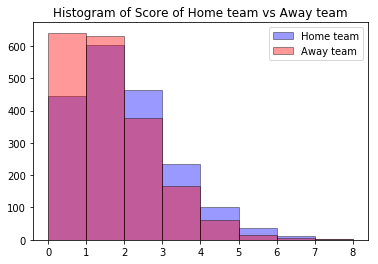

In [923]:
ax = plt.subplot()
_ = ax.hist(all_fixtures.home_score,alpha=0.4, color="blue",bins=(range(9)), edgecolor="black")
_ = ax.hist(all_fixtures.away_score,alpha=0.4, color="red",bins=(range(9)),  edgecolor="black")
_ = ax.set_title("Histogram of Score of Home team vs Away team")
_ = ax.legend(["Home team", "Away team"])

## all_players_groupby stats

In [924]:
train_seasons = [2015,2016,2017,2018]
test_seasons = [2019]

In [925]:
all_players_groupby_train = all_players_groupby[all_players_groupby['season'].isin(train_seasons)]
all_players_groupby_test = all_players_groupby[all_players_groupby['season'].isin(test_seasons)]

In [926]:
name_columns = ['name','count']
all_players_groupby_train_names = all_players_groupby_train[name_columns].groupby('name').sum().reset_index()
all_players_groupby_train_names.head()

,name,count
0,Adrien Silva,9
1,AdriÃ¡n,105
2,Alberto Moreno,70
3,Aleix GarcÃ­a,1
4,Alexandre Pato,1


In [927]:
test_names = all_players_groupby_test[name_columns].groupby('name').sum().reset_index()
test_names.head()

,name,count
0,Adrien Silva,1
1,Alberto Moreno,2
2,Alisson,38
3,Ander Herrera,16
4,Andreas Pereira,6


In [928]:
new_players = np.setdiff1d(test_names['name'],all_players_groupby_train_names['name'])
print("number of new players in test season: " +str(len(new_players)))

number of new players in test season: 128


In [929]:
recurring_players = np.intersect1d(test_names['name'],all_players_groupby_train_names['name'])
print("number of recurring players in test season: " +str(len(recurring_players)))

number of recurring players in test season: 334


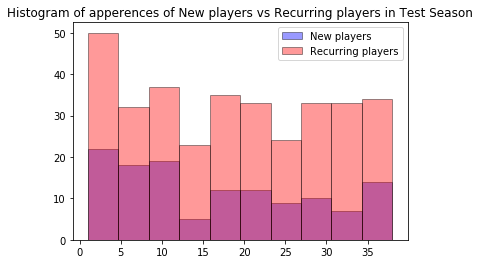

In [930]:
fig, ax = plt.subplots()
_ = ax.hist(test_names[test_names["name"].isin(new_players)]["count"],alpha=0.4, color="blue", edgecolor="black", label="New players")
_ = ax.hist(test_names[test_names["name"].isin(recurring_players)]["count"],alpha=0.4, color="red", edgecolor="black", label="Recurring players")
_ = ax.set_title("Histogram of apperences of New players vs Recurring players in Test Season")
_ = ax.legend(["New players", "Recurring players"])

In [931]:
print("Avarage apperance of New players: " +str(np.mean(test_names[test_names["name"].isin(new_players)]["count"])))
print("Avarage apperance of Recurring players: " +str(np.mean(test_names[test_names["name"].isin(recurring_players)]["count"])))

Avarage apperance of New players: 16.6796875
Avarage apperance of Recurring players: 18.637724550898202


In [932]:
sum_new = np.sum(test_names[test_names["name"].isin(new_players)]["count"])
sum_rec = np.sum(test_names[test_names["name"].isin(recurring_players)]["count"])
print("The overall appereances of New players in test season: " + str(sum_new))
print("The overall appereances of Recurring players in test season: " + str(sum_rec))
print("The ratio between overall appereances of New players and all the players in test season: " + str(sum_new/(sum_new+sum_rec)))

The overall appereances of New players in test season: 2135
The overall appereances of Recurring players in test season: 6225
The ratio between overall appereances of New players and all the players in test season: 0.2553827751196172


In [933]:
print("The average apperences of players in the Train season: " +str(np.mean(all_players_groupby_train_names["count"])))

The average apperences of players in the Train season: 37.238307349665924


In [934]:
test_names_recurring = test_names[test_names["name"].isin(recurring_players)].merge(all_players_groupby_train_names,on="name")

In [935]:
test_names_recurring.head()

,name,count_x,count_y
0,Adrien Silva,1,9
1,Alberto Moreno,2,70
2,Ander Herrera,16,76
3,Ayoze PÃ©rez,34,75
4,Azpilicueta,38,140


In [936]:
print("The average apperences of recurring players in the Train season: " +str(np.mean(test_names_recurring["count_y"])))

The average apperences of recurring players in the Train season: 56.625748502994014


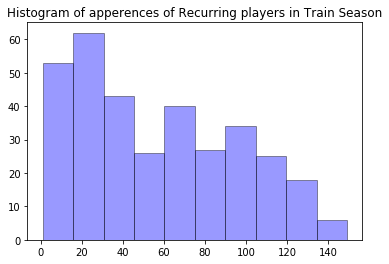

In [937]:
ax = plt.subplot()
_ = ax.hist(test_names_recurring["count_y"],alpha=0.4, color="blue", edgecolor="black")
_ = ax.set_title("Histogram of apperences of Recurring players in Train Season")

## Changing names to ids and setting names with no training a mock index

In [938]:
names_train = all_players_groupby_train_names.groupby(["name"]).sum().reset_index()
names_test = all_players_groupby_test[name_columns].groupby('name').sum().reset_index()
valid_players = names_train[names_train['count']>=1]
unvalid_players = np.setdiff1d(names_train.name,valid_players.name)
names_train.loc[names_train.name.isin(unvalid_players),'id'] = len(valid_players)
print(len(unvalid_players))
names_train["id"] = names_train.index
names_test = names_test.merge(names_train[["name","id"]], on="name", how="left").fillna(len(valid_players))
names = pd.concat([names_train,names_test]).groupby(["name","id"]).count().reset_index()
print(names)

0
                     name     id  count
0            Adrien Silva    0.0      2
1                 AdriÃ¡n    1.0      1
2          Alberto Moreno    2.0      2
3           Aleix GarcÃ­a    3.0      1
4          Alexandre Pato    4.0      1
5                 Alisson  898.0      1
6           Ander Herrera    5.0      2
7         Andreas Pereira  898.0      1
8            AndrÃ© Gomes  898.0      1
9                 Arbeloa    6.0      1
10           Ayoze PÃ©rez    7.0      2
11            Azpilicueta    8.0      2
12              BarragÃ¡n    9.0      1
13                Bernard  898.0      1
14               Bernardo  898.0      1
15         Bernardo Silva   10.0      2
16                  Bojan   11.0      1
17          Borja BastÃ³n   12.0      1
18                  Bruno   13.0      2
19               Camarasa  898.0      1
20             Carles Gil   14.0      1
21         Cesc FÃ bregas   15.0      2
22               Coutinho   16.0      1
23         CÃ©dric Soares   17.0      

## Changing all_fixtures to be index instead of names

In [939]:
number_players = 11
names_ids_dict = pd.Series(names.id.values,index=names.name).to_dict()
all_fixtures_copy = all_fixtures.copy()
players_columns = []
for which_team in ['home', 'away']:
    for i in range(1,number_players+1):
        players_columns.append(which_team +(str(i)))
for players_column in players_columns:
    all_fixtures_copy[players_column] = all_fixtures_copy[players_column].map(names_ids_dict)

In [940]:
all_fixtures_copy

,home_team,away_team,home1,home2,home3,home4,home5,home6,home7,home8,...,away5,away6,away7,away8,away9,away10,away11,home_score,away_score,season
0,arsenal-fc,aston-villa,281.0,698.0,540.0,66.0,35.0,627.0,95.0,83.0,...,833.0,334.0,525.0,217.0,147.0,234.0,14.0,5,0,2015
1,arsenal-fc,burnley-fc,880.0,524.0,698.0,66.0,212.0,62.0,83.0,607.0,...,795.0,288.0,277.0,764.0,267.0,600.0,360.0,3,0,2015
2,arsenal-fc,chelsea-fc,281.0,698.0,540.0,66.0,35.0,627.0,95.0,83.0,...,8.0,15.0,76.0,70.0,665.0,87.0,310.0,0,0,2015
3,arsenal-fc,crystal-palace,880.0,606.0,524.0,540.0,212.0,62.0,408.0,95.0,...,594.0,883.0,641.0,454.0,435.0,345.0,589.0,2,1,2015
4,arsenal-fc,everton-fc,281.0,524.0,32.0,540.0,35.0,627.0,83.0,346.0,...,564.0,419.0,652.0,352.0,739.0,736.0,518.0,2,0,2015
5,arsenal-fc,hull-city,880.0,524.0,698.0,66.0,35.0,408.0,83.0,607.0,...,149.0,115.0,837.0,412.0,646.0,388.0,100.0,2,2,2015
6,arsenal-fc,leicester-city,281.0,698.0,540.0,66.0,35.0,843.0,627.0,83.0,...,731.0,445.0,269.0,619.0,331.0,726.0,148.0,2,1,2015
7,arsenal-fc,liverpool-fc,281.0,698.0,540.0,66.0,35.0,627.0,95.0,83.0,...,16.0,481.0,55.0,325.0,450.0,541.0,712.0,4,1,2015
8,arsenal-fc,manchester-city,880.0,606.0,698.0,540.0,66.0,408.0,627.0,95.0,...,598.0,421.0,40.0,347.0,21.0,27.0,531.0,2,2,2015
9,arsenal-fc,manchester-united,880.0,524.0,698.0,66.0,212.0,62.0,408.0,95.0,...,848.0,629.0,163.0,590.0,893.0,866.0,734.0,1,2,2015


In [941]:
all_fixtures

,home_team,away_team,home1,home2,home3,home4,home5,home6,home7,home8,...,away5,away6,away7,away8,away9,away10,away11,home_score,away_score,season
0,arsenal-fc,aston-villa,David Ospina,Per Mertesacker,Laurent Koscielny,Nacho Monreal,HÃ©ctor BellerÃ­n,Mesut Ãzil,Aaron Ramsey,Santi Cazorla,...,Tom Cleverley,Fabian Delph,Kieran Richardson,Carlos SÃ¡nchez,Andreas Weimann,Christian Benteke,Carles Gil,5,0,2015
1,arsenal-fc,burnley-fc,Wojciech SzczÄsny,Kieran Gibbs,Per Mertesacker,Nacho Monreal,Calum Chambers,Mikel Arteta,Santi Cazorla,Mathieu Flamini,...,Stephen Ward,Dean Marney,David Jones,Scott Arfield,Danny Ings,Marvin Sordell,George Boyd,3,0,2015
2,arsenal-fc,chelsea-fc,David Ospina,Per Mertesacker,Laurent Koscielny,Nacho Monreal,HÃ©ctor BellerÃ­n,Mesut Ãzil,Aaron Ramsey,Santi Cazorla,...,Azpilicueta,Cesc FÃ bregas,Ramires,Oscar,Nemanja MatiÄ,Willian,Eden Hazard,0,0,2015
3,arsenal-fc,crystal-palace,Wojciech SzczÄsny,Mathieu Debuchy,Kieran Gibbs,Laurent Koscielny,Calum Chambers,Mikel Arteta,Jack Wilshere,Aaron Ramsey,...,Martin Kelly,Yannick Bolasie,Mile Jedinak,Joe Ledley,Jason Puncheon,Fraizer Campbell,Marouane Chamakh,2,1,2015
4,arsenal-fc,everton-fc,David Ospina,Kieran Gibbs,Gabriel Paulista,Laurent Koscielny,HÃ©ctor BellerÃ­n,Mesut Ãzil,Santi Cazorla,Francis Coquelin,...,Luke Garbutt,James McCarthy,Muhamed BeÅ¡iÄ,Gareth Barry,Ross Barkley,Romelu Lukaku,Kevin Mirallas,2,0,2015
5,arsenal-fc,hull-city,Wojciech SzczÄsny,Kieran Gibbs,Per Mertesacker,Nacho Monreal,HÃ©ctor BellerÃ­n,Jack Wilshere,Santi Cazorla,Mathieu Flamini,...,Andrew Robertson,Ahmed El Mohamady,Tom Huddlestone,Jake Livermore,Momo DiamÃ©,Hatem Ben Arfa,Abel HernÃ¡ndez,2,2,2015
6,arsenal-fc,leicester-city,David Ospina,Per Mertesacker,Laurent Koscielny,Nacho Monreal,HÃ©ctor BellerÃ­n,TomÃ¡Å¡ RosickÃ½,Mesut Ãzil,Santi Cazorla,...,Robert Huth,Jeffrey Schlupp,Danny Simpson,Matty James,Esteban Cambiasso,Riyad Mahrez,Andrej KramariÄ,2,1,2015
7,arsenal-fc,liverpool-fc,David Ospina,Per Mertesacker,Laurent Koscielny,Nacho Monreal,HÃ©ctor BellerÃ­n,Mesut Ãzil,Aaron Ramsey,Santi Cazorla,...,Coutinho,Jordan Henderson,Lucas Leiva,Emre Can,Joe Allen,Lazar MarkoviÄ,Raheem Sterling,4,1,2015
8,arsenal-fc,manchester-city,Wojciech SzczÄsny,Mathieu Debuchy,Per Mertesacker,Laurent Koscielny,Nacho Monreal,Jack Wilshere,Mesut Ãzil,Aaron Ramsey,...,MartÃ­n Demichelis,James Milner,JesÃºs Navas,Frank Lampard,David Silva,Fernandinho,Kun AgÃ¼ero,2,2,2015
9,arsenal-fc,manchester-united,Wojciech SzczÄsny,Kieran Gibbs,Per Mertesacker,Nacho Monreal,Calum Chambers,Mikel Arteta,Jack Wilshere,Aaron Ramsey,...,Tyler Blackett,Michael Carrick,Antonio Valencia,Marouane Fellaini,Ãngel Di MarÃ­a,Wayne Rooney,Robin van Persie,1,2,2015


In [942]:
all_fixtures_copy["home_point"] = 2
all_fixtures_copy.loc[all_fixtures_copy["home_score"]<all_fixtures_copy["away_score"],"home_point"] = 0
all_fixtures_copy.loc[all_fixtures_copy["home_score"]==all_fixtures_copy["away_score"],"home_point"] = 1

In [943]:
all_fixtures_copy

,home_team,away_team,home1,home2,home3,home4,home5,home6,home7,home8,...,away6,away7,away8,away9,away10,away11,home_score,away_score,season,home_point
0,arsenal-fc,aston-villa,281.0,698.0,540.0,66.0,35.0,627.0,95.0,83.0,...,334.0,525.0,217.0,147.0,234.0,14.0,5,0,2015,2
1,arsenal-fc,burnley-fc,880.0,524.0,698.0,66.0,212.0,62.0,83.0,607.0,...,288.0,277.0,764.0,267.0,600.0,360.0,3,0,2015,2
2,arsenal-fc,chelsea-fc,281.0,698.0,540.0,66.0,35.0,627.0,95.0,83.0,...,15.0,76.0,70.0,665.0,87.0,310.0,0,0,2015,1
3,arsenal-fc,crystal-palace,880.0,606.0,524.0,540.0,212.0,62.0,408.0,95.0,...,883.0,641.0,454.0,435.0,345.0,589.0,2,1,2015,2
4,arsenal-fc,everton-fc,281.0,524.0,32.0,540.0,35.0,627.0,83.0,346.0,...,419.0,652.0,352.0,739.0,736.0,518.0,2,0,2015,2
5,arsenal-fc,hull-city,880.0,524.0,698.0,66.0,35.0,408.0,83.0,607.0,...,115.0,837.0,412.0,646.0,388.0,100.0,2,2,2015,1
6,arsenal-fc,leicester-city,281.0,698.0,540.0,66.0,35.0,843.0,627.0,83.0,...,445.0,269.0,619.0,331.0,726.0,148.0,2,1,2015,2
7,arsenal-fc,liverpool-fc,281.0,698.0,540.0,66.0,35.0,627.0,95.0,83.0,...,481.0,55.0,325.0,450.0,541.0,712.0,4,1,2015,2
8,arsenal-fc,manchester-city,880.0,606.0,698.0,540.0,66.0,408.0,627.0,95.0,...,421.0,40.0,347.0,21.0,27.0,531.0,2,2,2015,1
9,arsenal-fc,manchester-united,880.0,524.0,698.0,66.0,212.0,62.0,408.0,95.0,...,629.0,163.0,590.0,893.0,866.0,734.0,1,2,2015,0


In [944]:
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers import MaxPooling1D,Convolution1D
from keras.layers.normalization  import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

## Creating a weights matrix for the players

In [945]:
number_of_players = len(names)
starting_lineups = number_players * 2

In [1120]:
vec_size = 5
vecs = np.random.normal(size=(int(np.max(names.id)), vec_size))
vecs = np.append(vecs,np.mean(vecs, axis=0).reshape(1,vec_size)).reshape(int(np.max(names.id))+1,vec_size)
print(vecs.shape)

(899, 5)


## Data Split

In [1170]:
train_valid_ratio=0.03
train_data = all_fixtures_copy[all_fixtures_copy.season.isin(train_seasons)]
# valid_index = np.random.choice(train_data.index, int(len(train_data)*train_valid_ratio), replace=False)
valid_index = train_data[-1*int(train_valid_ratio*len(train_data)):].index
valid = train_data[train_data.index.isin(valid_index)][players_columns].values
# valid_label = pd.get_dummies(train_data[train_data.index.isin(valid_index)]['home_point']).values
valid_label = train_data[train_data.index.isin(valid_index)][['home_score','away_score']].values
trn = train_data[~train_data.index.isin(valid_index)].sort_values('home_team')[players_columns].values
# trn_label = pd.get_dummies(train_data[~train_data.index.isin(valid_index)]['home_point']).values
trn_label = train_data[~train_data.index.isin(valid_index)].sort_values('home_team')[['home_score','away_score']].values
test = all_fixtures_copy[all_fixtures_copy.season.isin(test_seasons)][players_columns].values
# test_label = pd.get_dummies(all_fixtures_copy[all_fixtures_copy.season.isin(test_seasons)]['home_point']).values
test_label = all_fixtures_copy[all_fixtures_copy.season.isin(test_seasons)][['home_score','away_score']].values

## Augmentation

In [984]:
# trn_2 = trn.copy()
# trn_label_2 = trn_label.copy()
# # white_array = np.random.normal(size=(len(trn_label_2),2),loc=0,scale=0.05)
# # trn_label_2 = trn_label + white_array
# # trn_label_2
# trn = pd.concat([trn_2,trn_2,trn_2,trn_2])
# trn_label = pd.concat([trn_label_2,trn_label_2,trn_label_2,trn_label_2])
# len(trn)

In [1171]:
def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

In [1188]:
model = Sequential([
    Embedding(vecs.shape[0], vec_size, input_length=starting_lineups,dropout=0.1, weights=[vecs], trainable=True),
    BatchNormalization(),
    Flatten(),
    Dense(5, activation='relu'),
    Dropout(0.4),
    BatchNormalization(),
    Dropout(0.4),
    Dense(2,activation='linear')])

/home/zencity/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  


In [1189]:
model.compile(loss='mae', optimizer=Adam(lr=0.001))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_108 (Embedding)    (None, 22, 5)             4495      
_________________________________________________________________
batch_normalization_123 (Bat (None, 22, 5)             20        
_________________________________________________________________
flatten_103 (Flatten)        (None, 110)               0         
_________________________________________________________________
dense_211 (Dense)            (None, 5)                 555       
_________________________________________________________________
dropout_166 (Dropout)        (None, 5)                 0         
_________________________________________________________________
batch_normalization_124 (Bat (None, 5)                 20        
_________________________________________________________________
dropout_167 (Dropout)        (None, 5)                 0         
__________

In [1190]:
file_path = ".model_weights_temp.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=5)
model.fit(trn, trn_label, validation_data=(valid, valid_label), nb_epoch=50, batch_size=8, callbacks=callbacks)

/home/zencity/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 1475 samples, validate on 45 samples
Epoch 1/50
1475/1475 [==============================] - 8s 5ms/step - loss: 1.7331 - val_loss: 1.2827
Epoch 2/50
1475/1475 [==============================] - 1s 780us/step - loss: 1.4314 - val_loss: 1.1256
Epoch 3/50
1475/1475 [==============================] - 1s 772us/step - loss: 1.2696 - val_loss: 1.0317
Epoch 4/50
1475/1475 [==============================] - 1s 793us/step - loss: 1.1304 - val_loss: 0.9719
Epoch 5/50
1475/1475 [==============================] - 1s 767us/step - loss: 1.0734 - val_loss: 0.9343
Epoch 6/50
1475/1475 [==============================] - 1s 775us/step - loss: 1.0271 - val_loss: 0.9106
Epoch 7/50
1475/1475 [==============================] - 1s 776us/step - loss: 1.0040 - val_loss: 0.8931
Epoch 8/50
1475/1475 [==============================] - 1s 775us/step - loss: 0.9827 - val_loss: 0.8809
Epoch 9/50
1475/1475 [==============================] - 1s 800us/step - loss: 0.9657 - val_loss: 0.8750
Epoch 10/50
1475/147

In [1191]:
print(vecs[750])
print(model.layers[0].get_weights()[0][750])

[ 0.99938609 -0.03963027  0.45981887 -1.21113664 -1.41942819]
[ 1.0088292 -0.1535704  0.5227005 -1.23141   -1.41815  ]


In [1192]:
model.load_weights(filepath=file_path)

print("Train evaluate:")
print(model.evaluate(trn, trn_label, verbose=1))
print("####################")
print("Valid evaluate:")
print(model.evaluate(valid, valid_label, verbose=1))
print("####################")
print("Test evaluate:")
print(model.evaluate(test, test_label, verbose=1))

Train evaluate:
1475/1475 [==============================] - 0s 89us/step
0.9219811973733417
####################
Valid evaluate:
45/45 [==============================] - 0s 131us/step
0.8380434499846564
####################
Test evaluate:
380/380 [==============================] - 0s 87us/step
0.9540351610434683


In [1193]:
home_true = test_label
home_label = model.predict(test)
prediction_mae = metrics.mean_absolute_error(y_true=home_true,y_pred=home_label)
tp=np.array(np.mean(home_true[:,0])*np.ones(len(home_true)))
fp=np.array(np.mean(home_true[:,1])*np.ones(len(home_true)))
baseline = np.vstack((tp, fp)).T
baseline_mae = metrics.mean_absolute_error(y_true=home_true,y_pred=baseline)
print("prediction score is %.3f" %(prediction_mae))
print("baseline score is %.3f" %(baseline_mae))

prediction score is 0.954
baseline score is 1.010


In [848]:
metrics.accuracy_score(np.argmax(test_label, axis=1),np.argmax(model.predict(test),axis=1))

0.45526315789473687

In [1022]:
baseline.size

760

In [1024]:
unique_elements, counts_elements = np.unique(np.concatenate(trn), return_counts=True)
trn_values = pd.DataFrame(columns=['id','count'])
trn_values['id'] = unique_elements
trn_values['count'] = counts_elements
unique_elements, counts_elements = np.unique(np.concatenate(valid), return_counts=True)
valid_values = pd.DataFrame(columns=['id','count'])
valid_values['id'] = unique_elements
valid_values['count'] = counts_elements

In [1025]:
np.setdiff1d(valid_values.id,trn_values.id)

array([675.])

In [1026]:
all_fixtures_test = all_fixtures[all_fixtures["season"].isin(test_seasons)]
len(all_fixtures_test[all_fixtures_test["home_score"]==all_fixtures_test["away_score"]])/len(all_fixtures_test)

0.1868421052631579

In [1066]:
table = pd.DataFrame()
table["home_pred"] = home_label[:,0]
table["away_pred"] = home_label[:,1]
table["home_truth"] = home_true[:,0]
table["away_truth"] = home_true[:,1]
sum(np.abs(table["home_pred"] - table["away_pred"]) < 0.2)
table["point_truth"] = 3
table.loc[table["home_truth"]<table["away_truth"],"point_truth"] = 0
table.loc[table["home_truth"]==table["away_truth"],"point_truth"] = 1
table["point_pred"] = 3
table.loc[table["home_pred"]<table["away_pred"],"point_pred"] = 0
table.loc[np.abs(table["home_pred"] - table["away_pred"]) < 0.4,"point_pred"] = 1
table["baseline"] = 1

In [1067]:
print(metrics.mean_absolute_error(y_true=table["point_truth"],y_pred=table["point_pred"]))
print(metrics.mean_absolute_error(y_true=table["point_truth"],y_pred=table["baseline"]))

1.2526315789473683
1.2894736842105263


In [1194]:
pca = PCA(n_components=3)
pca.fit(model.layers[0].get_weights()[0])

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [1195]:
pca.explained_variance_ratio_

array([0.22302905, 0.20585242, 0.2000793 ], dtype=float32)

In [1196]:
componets = pca.transform(model.layers[0].get_weights()[0])
componets_df = pd.DataFrame()
componets_df["0"] = componets[:,0]
componets_df["1"] = componets[:,1]
componets_df["2"] = componets[:,2]

In [1197]:
componets_df.sort_values("0").index[-10:]

Int64Index([532, 483, 495, 172, 851, 781, 405, 461, 609, 36], dtype='int64')

In [1199]:
names[names["id"].isin(componets_df.sort_values("0").index[:10])]

,name,id,count
224,Ben Mee,186.0,2
406,Fredrik Ulvestad,349.0,1
589,Kasey Palmer,511.0,1
658,Mamadou Sakho,570.0,2
679,Marouane Chamakh,589.0,1
815,Pierre-Emile HÃ¸jbjerg,709.0,2
908,Stefano Okaka,791.0,1
924,Steven N'Zonzi,806.0,1
997,Will Hughes,876.0,2
1023,Ãtienne Capoue,895.0,2


In [1103]:
all_players_groupby[all_players_groupby["name"].isin(names[names["id"].isin(componets_df.sort_values("0").index[:10])]["name"])]

,name,team,season,count,id
176,Marcos Alonso,chelsea-fc,2017,30,81
177,Marcos Alonso,chelsea-fc,2018,33,81
178,Marcos Alonso,chelsea-fc,2019,31,81
193,Nacho Monreal,arsenal-fc,2015,26,89
194,Nacho Monreal,arsenal-fc,2016,36,89
195,Nacho Monreal,arsenal-fc,2017,35,89
196,Nacho Monreal,arsenal-fc,2018,26,89
197,Nacho Monreal,arsenal-fc,2019,21,89
608,Cheikhou KouyatÃ©,crystal-palace,2019,21,272
609,Cheikhou KouyatÃ©,west-ham-united,2015,30,272
